In [26]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs, expm_multiply
from numpy import linalg as LA
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from scipy.optimize import minimize
%matplotlib inline

In [ ]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

In [ ]:
L = 3
Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 1-2*int(format(j, '0{}b'.format(L))[i])
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 1-2*int(format(j, '0{}b'.format(L))[i])
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

Sm = [Sp[i].T for i in range(L)]
Sx = [Sp[i]+Sm[i] for i in range(L)]
Sy = [-1j*Sz[i] @ Sx[i] for i in range(L)]
SxTot = sum(Sx)
SyTot = sum(Sy)

# Exact time evolution

In [ ]:
H = sum([Heis[i][(i+1)%L] for i in range(L-1)]) / 4
# H = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)])) / 4 # H plus Z_i Z_{i+2}
# Hzzz = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) + sum([diags(Heis[i][(i+3)%L].diagonal()) for i in range(L)])) / 4
# e, v = eigs(H, 30)

# ind = e.argsort()
# e = e[idx]
# v = v[:, idx]
# np.conj(v.T) @ H @ v - np.diag(e), decimals=3)

In [ ]:
H.toarray()

In [ ]:
tf = 50
dt = tf / 200
Nt = int(tf / dt)
c = ['1','1','0'] #[str((1 + (-1)**(i+1)) // 2) for i in range(L)]
UnitVector = lambda c: np.eye(2**L)[c]
init = UnitVector(int(''.join(c), 2))

In [ ]:
revos = [np.zeros(2**L) for i in range(Nt+1)]
revos[0] = init
for i in range(Nt):
    # scipy.sparse.linalg.expm_multiply
    revos[i+1] = expm(-1j * H * dt) @ revos[i]

In [ ]:
Szt = []

def expectation(op, vec):
    return np.conj(vec) @ op @ vec / 2

for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ (Sz[0]) @ revos[i] / 2)

In [ ]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.axhline(y=0, color='k')

# Trotter Evolution

In [ ]:
def TrotterEvolve(tf, nt, init):
    dt = tf / nt
    if (L % 2 == 0):
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4) # 0 indexing, this is actually even indices
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L-1, 2)]) / 4) # L for periodic bdy. 0 indexing, this is actually the odd indices
        UTrotter = UOdd @ UEven
        # UZ = expm(-1j * dt * sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) / 2)
        # UTrotter = UEven @ UOdd @ UZ
    else:
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4)
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L, 2)]) / 4)
        # UBdy = expm(-1j * dt * Heis[L-1][0] / 4)
        UTrotter = UOdd @ UEven
        # UZ = expm(-1j * dt * sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) / 2)
        # UTrotter = UEven @ UOdd @ UBdy @ UZ
    psi_trot = init
    for i in range(nt):
        psi_trot = UTrotter @ psi_trot
    return psi_trot

vec = TrotterEvolve(np.pi/3,1,init)
print(expectation(Sz[0], vec))
vec
# np.around(vec, decimals=2)

In [ ]:
vec1 = np.array([ 0.00000000e+00+0.00000000e+00j, -3.75000000e-01+4.33012702e-01j,
       -3.75000000e-01-6.49519053e-01j,  0.00000000e+00+0.00000000e+00j,
       -2.50000000e-01+2.16506351e-01j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -2.31977337e-17-3.19676110e-18j])
print(expectation(Sz[0], vec1))
print(abs(np.conj(vec) @ vec1)**2)

In [ ]:
TrotterFixStepList = [init]
for i in range(Nt):
    TrotterFixStepList.append(TrotterEvolve((i+1)*dt, 1, init))
TrotterFixStepSz = []
for i in range(len(TrotterFixStepList)):
    TrotterFixStepSz.append(np.conj(TrotterFixStepList[i]) @ Sz[0] @ TrotterFixStepList[i] / 2)

# Ansatz

In [ ]:
p = 1
def Ansatz(params):
    # check for correct length of params
    psi_ansz = init
    for i in range(p): # len(params) // L
        if (L % 2 == 0):
            for j in range(1, L-1, 2): # L for periodic bdy
                psi_ansz = expm_multiply(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]/4, psi_ansz)
            for j in range(0, L-1, 2):
                psi_ansz = expm_multiply(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]/4, psi_ansz)
        else:
            for j in range(1, L, 2):
                psi_ansz = expm_multiply(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]/4, psi_ansz)
            for j in range(0, L-1, 2):
                psi_ansz = expm_multiply(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]/4, psi_ansz)
            # psi_ansz = expm_multiply(-1j * params[(L*i)+L-1] * Heis[L-1][0]/4, psi_ansz)
        
        
        # for j in range(L):
        #     psi_ansz = expm(-1j * params[(2*L*i)+L+j] * diags(Heis[j][(j+2)%L].diagonal()).tocsc()) @ psi_ansz
    return psi_ansz

def Loss(x, target, O):
    psi_ansz = Ansatz(x)
    Sz_ansz = np.conj(psi_ansz) @ (O) @ psi_ansz / 2
    Sz_ex = np.conj(target) @ (O) @ target / 2
    return abs(Sz_ansz - Sz_ex)

def Fidelity(x, target):
    psi_ansz = Ansatz(x)
    return 1 - abs(np.conj(target) @ psi_ansz)**2

In [ ]:
init_params = np.random.uniform(0, 2*np.pi, (L-1)*p)
sol = minimize(fun=Fidelity, x0=init_params, args=(revos[-1]))
sol

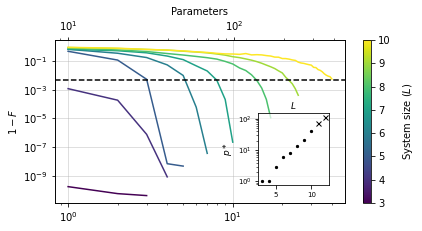

In [25]:
Ls = [[1.7996267587250258e-10, 5.878299180750446e-11, 4.295401812015598e-11],
     [0.0011696504177758317, 0.0001847764634799076, 7.770443912269443e-07, 8.577016519240032e-10],
     [0.4639926762403798, 0.11391314946947262, 0.0052318151198888965, 7.07515616982235e-09, 4.817845151716682e-09],   
     [0.6363176386045497, 0.3392298484219568, 0.17048011852949127, 0.052668122694601784, 0.00967727126882913, 6.0256055398317797e-05, 3.719534741541963e-08],
     [0.6416560976244899, 0.5086738165494462, 0.36342221837249766, 0.21626469635978224, 0.12237679637738229, 0.045167593212329396, 0.019818305324384538, 0.004553513550590642, 0.0002063399825817802, 2.2342880081627215e-07],
     [0.7590718540880695, 0.5719211366047965, 0.44510673104760407, 0.3241760396769466, 0.2550839283040911, 0.20338644928503405, 0.16657267588874713, 0.13303684756303158, 0.09179578796168021, 0.06102443877810375, 0.032180786182541075, 0.021368967806325422, 0.010754411919488305, 0.0043950994366458995, 0.0012846150810468914, 0.00020951238811922623, 1.1106172605279685e-05],
     [0.8487796466464832, 0.7246713564910872, 0.6212977022476487, 0.5601619345396789, 0.4708760688783845, 0.41385549557756507, 0.3608916901805358, 0.30257921928460585, 0.24985423332471882, 0.19539132415233107, 0.1679920211863423, 0.13669538443585097, 0.11212563368131197, 0.08873980822580929, 0.06822397613094205, 0.05092762634877268, 0.03898776643879624, 0.02921738040071047, 0.020098550656726288, 0.014498611773404769, 0.0071355138558909514, 0.0043125361783976635, 0.002548221151697283, 0.0011333996251954304, 0.0004074573587542485],
    [0.8743803794511876, 0.7602827036510854, 0.6283331545866673, 0.5628693380619201, 0.4921650094542621, 0.4256666141075628, 0.38455154797254093, 0.33474153611510793, 0.30555276126916875, 0.2997335321936316, 0.28403853926060596, 0.32331078335113633, 0.2605064704572483, 0.2701202553798495, 0.25988398779544275, 0.23296151808521248, 0.21691028941228307, 0.18272598198029488, 0.18016026093971216, 0.14507519284391246, 0.14432891969153894, 0.13215513174156102, 0.11645455273223815, 0.10780069121860303, 0.08184172387280209, 0.07124292315053182, 0.06695249692045613, 0.06004606181960437, 0.05447963474429951, 0.05066997157910613, 0.035307219169577686, 0.03405049668035065, 0.024741642898890692, 0.021846105971423002, 0.017336086230235193, 0.012528126860723132, 0.01008166471798333, 0.008636011985746816, 0.007922392087377883, 0.005485597676916254]
 ]

fig, ax = plt.subplots(1, 1, figsize=(6.5,3))

color = matplotlib.cm.viridis
c = np.arange(3, 3 + len(Ls))
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=color)
cmap.set_array([])

ax.set_prop_cycle('color', [color(i) for i in np.linspace(0, 1, len(Ls))])


for i in range(len(Ls)):
    ax.plot(np.array([j for j in range(1, len(Ls[i])+1)]), Ls[i])

ax_top = ax.twiny()
ax_top.set_prop_cycle('color', [color(i) for i in np.linspace(0, 1, len(Ls))])

# for i in range(len(Ls)):
ax_top.plot(np.array([j*(i+3) for j in range(0, len(Ls[-1]))]), Ls[-1], alpha=0)
ax_top.set_xlabel('Parameters')
ax_top.set_xscale('log')

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

cbar = plt.colorbar(cmap, ticks=c)
cbar.set_label('System size ($L$)')
cbar.ax.get_yaxis().labelpad = 10

plt.axhline(5e-3, color='k', linestyle='--')
ax.set_ylabel('$1-F$')
# plt.title('$H = \sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j$')
# plt.ylabel('$1 - | \langle \psi (t) | \Phi_p(\\vartheta) \\rangle |$')
# ax.set_xlabel('$p$')
plt.yscale('log')
ax.grid(True, alpha=0.5)

Lstar = np.array([1, 1, 3, 6, 8, 14, 22, 41])
L = np.array([3, 4, 5, 6, 7, 8, 9, 10])
Lpred = [11, 12]
Lstarpred = [76, 120]
ax2 = plt.axes([0.56, 0.21, 0.15, 0.33])
ax2.patch.set_alpha(0.7)
ax2.set_xlabel('$L$', fontsize=9)
ax2.set_ylabel('$p*$', fontsize=9)
ax2.xaxis.set_label_position('top') 
ax2.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax2.scatter(L, Lstar, s=5, c='k')
ax2.plot(Lpred, Lstarpred, markersize=5, marker='x', markeredgewidth=1, c='k', linestyle='None')
ax2.set_yscale('log')


ax.set_xscale('log')
plt.savefig('figures/p_vs_fidelity.svg', dpi=600, transparent=False, bbox_inches='tight')


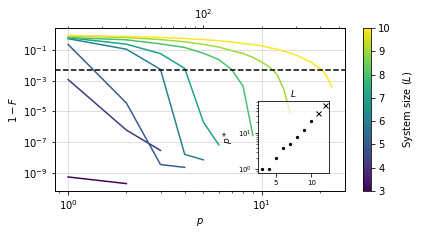

In [23]:
Ls = [[5.588469909056926e-10, 2.0827159996628098e-10],
     [0.001168806471793331, 6.137607163125836e-07, 2.9467021409601557e-08],
     [0.221483226411549, 3.516649276943173e-05, 3.5626192662618907e-09, 2.3491798506469763e-09],
     [0.5235831350848252, 0.1083608801605783, 0.005335858738842259, 1.6297208194071544e-08, 7.191482065405097e-09],
     [0.6040549826328518, 0.23093713565766655, 0.05580251843277639, 0.006179206353788902, 1.9743014617601418e-06, 6.762318172093273e-08],
     [0.6176635173647363, 0.4390706383021266, 0.2408873676967919, 0.14031169478591124, 0.05890306619134159, 0.02307252601390696, 0.005092728379774802, 0.0004371954153208346, 2.697683505470394e-07],
     [0.785334008250023, 0.613777408810309, 0.4576167020008981, 0.3288543148417202, 0.22143088145446158, 0.14860190229834255, 0.08759629838864513, 0.05802319045287724, 0.031662276466621564, 0.01587701353584159, 0.007213445838580079, 0.0024537179100346806, 0.0002624472754672036, 7.774376831970464e-06],
     [0.8610560425939218, 0.7231270541629369, 0.6285820336580716, 0.5370094711445761, 0.4586670741282329, 0.3807929396950779, 0.3174909773888193, 0.2513449067963391, 0.2195720123424823, 0.1836289000938064, 0.13420489033620941, 0.10721758114982793, 0.08139500801780553, 0.06053323515587661, 0.04577449938456679, 0.031191148885733266, 0.02140432456271879, 0.015623953576980876, 0.008632197587004065, 0.006153346788576708, 0.003555021475440623, 0.0012671810611337708, 0.00041213024535813325]]

fig, ax = plt.subplots(1, 1, figsize=(6.5,3))

color = matplotlib.cm.viridis
c = np.arange(3, 3 + len(Ls))
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=color)
cmap.set_array([])

ax.set_prop_cycle('color',[color(i) for i in np.linspace(0, 1, len(Ls))])

for i in range(len(Ls)):
    ax.plot(np.array([j for j in range(1, len(Ls[i])+1)]), Ls[i])
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax_top = ax.twiny()
ax_top.set_prop_cycle('color',[color(i) for i in np.linspace(0, 1, len(Ls))])

ax_top.plot(np.array([2*j*(i+3) for j in range(1, len(Ls[-1])+1)]), Ls[-1], alpha=0)
# ax_top.set_xlabel('Parameters')
ax_top.set_xscale('log')

cbar = plt.colorbar(cmap, ticks=c)
cbar.set_label('System size ($L$)')
cbar.ax.get_yaxis().labelpad = 10

plt.axhline(5e-3, color='k', linestyle='--')
ax.set_ylabel('$1-F$')
ax.set_xlabel('$p$')
ax.grid(True, alpha=0.5)

LHz = np.array([3, 4, 5, 6, 7, 8, 9, 10])
LstarHz = np.array([1, 1, 2, 4, 5, 8, 12, 21])
LHzpred = [11, 12]
LstarHzpred = [36, 61]

ax2 = plt.axes([0.56, 0.21, 0.15, 0.33])
ax2.patch.set_alpha(0.7)
ax2.set_xlabel('$L$', fontsize=9)
ax2.set_ylabel('$p*$', fontsize=9)
ax2.xaxis.set_label_position('top') 
ax2.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax2.scatter(LHz, LstarHz, s=5, c='k')
ax2.plot(LHzpred, LstarHzpred, markersize=5, marker='x', markeredgewidth=1, c='k', linestyle='None')
# ax2.plot([-1, -1], [1, 1], 'red', linewidth=1)

ax2.set_yscale('log')
# ax2.set_xscale('log')


# plt.legend(loc='lower right')
ax.set_yscale('log')
ax.set_xscale('log')
# plt.xlim([0,11])
plt.savefig('figures/p_vs_fidelityHz.svg', dpi=600, transparent=False, bbox_inches='tight')

In [ ]:

LstarH = np.array([1, 1, 3, 4, 8, 12, 23, 34, 59])
L = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11])
LstarHparams = np.multiply(LstarH, L)
LHz = np.array([3, 4, 5, 6, 7, 8, 9, 10])
LstarHz = np.array([1, 1, 2, 4, 5, 8, 12, 21])
LstarHzparams = np.multiply(LstarHz*2, LHz)
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
ax[0].set(ylabel='$p*$', xlabel='$L$')
# ax[0].title('L vs p* for Heisenberg models')
ax[0].loglog(L, LstarH, label='$H = J\sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j$')
ax[0].loglog(LHz, LstarHz, label='$H = J\sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j + \\frac{J}{4}\sum_i Z_i Z_{i+2}$')
ax[1].loglog(L, LstarHparams)
ax[1].loglog(LHz, LstarHzparams)
ax[1].set(ylabel='$p*$ (# of params)', xlabel='$L$')

ax[0].legend(loc='upper left')
fig.tight_layout()

# plt.savefig('figures/L_vs_pstar', dpi=300, transparent=False, bbox_inches='tight')
